# Content

>[Content](#scrollTo=ugRtGL5_kDhj)

>[Task](#scrollTo=AO0_zhK1k27I)

>[I Libraries and Functions](#scrollTo=sCG_g7USyYQT)

>>[1 Import libraries](#scrollTo=QvJBtShGOQoq)

>>[2 Additional functions](#scrollTo=2PFzi0D8OWza)

>[II About DATA](#scrollTo=lmkq0eHhzus1)

>>[3 Load data](#scrollTo=1bMx0u_uOzCj)

>>[4 Review data](#scrollTo=UxF3r92YyQoW)

>>>[4.1 Save review data](#scrollTo=SzLJgVu_y_ZT)

>>>[4.2 Load review data](#scrollTo=qd4ywGQozI_J)

>>[5 Split data](#scrollTo=OS0p7mmVzP3C)

>>>[5.1. Save split data](#scrollTo=Fi7WXaG7z895)

>>>[5.2 Load split data](#scrollTo=Aq3Ut4-D0BTe)

>[III PIPELINE](#scrollTo=bh7A2NpL0GbU)

>>[6 Make Pipeline](#scrollTo=DY8tFXyP0MM0)

>>[7 Create models params](#scrollTo=_aC8bn9dyfTS)

>[IV LogReg](#scrollTo=zHtEAHvGudqK)

>>[8 Learning model](#scrollTo=CHtzOK9P0SkI)

>>>[8.1 Learn with high frequency](#scrollTo=fS4t5cPrkRct)

>>>>[8.1.1 ROC curve plot](#scrollTo=p5XoDmNA0Yt4)

>>>>[8.1.2 Cnfusion matrix plot](#scrollTo=HPuGLstW0dvr)

>>>[8.2 Learn with middle frequency](#scrollTo=fk8Twcqozw2Z)

>>>>[8.2.1 ROC curve plot](#scrollTo=c1UpbDO5GqSu)

>>>>[8.2.2 Cnfusion matrix plot](#scrollTo=8C_Yb2_KGx2M)

>>>[8.3 Learn with lower frequency](#scrollTo=gCnPW6lOHN5H)

>>>>[8.3.1 ROC curve plot](#scrollTo=jGAjTfk5HWcV)

>>>>[8.3.2 Cnfusion matrix plot](#scrollTo=EdUJo4tGHWnT)

>>[9 SAVE Logreg model](#scrollTo=khTG-NcF00TW)

>>[10 Testing of model](#scrollTo=-WU1cTd30t_H)

>>>[10.1 LOAD Logreg model](#scrollTo=jPXuQErlt9Xm)

>>>[10.2 Testing model](#scrollTo=VO4lf6eNqLn6)

>[IV Neural Network](#scrollTo=SM8QBHHkYKkY)

>>[11 Check device](#scrollTo=hiErtrMzqnhB)

>>[12 Split data](#scrollTo=1zUIfWdGss5c)

>>[13 Preprocessing data](#scrollTo=MGYwgqixsGXs)

>>[14 Create DataLoader](#scrollTo=7uwXFW2JzTIR)

>>[15 Create Model](#scrollTo=cBZfjo410cKl)

>>[16 Create optimizer and function loss](#scrollTo=dnOobGnrEEAF)

>>[17 Learn of model](#scrollTo=p5qMRFhhEUOb)

>>[18 Visualisation of result learning model](#scrollTo=01gLWoZ-SAiL)



# Task

* Задание 1.

**Задание**: обучите три классификатора:

1) на токенах с высокой частотой

2) на токенах со средней частотой

3) на токенах с низкой частотой


Сравните полученные результаты, оцените какие токены наиболее важные для классификации.


* Задание 2.

найти фичи с наибольшей значимостью, и вывести их


* Задание 3.

1) сравнить count/tf-idf/hashing векторайзеры/полносвязанную сетку (построить classification_report)

2) подобрать оптимальный размер для hashing векторайзера

3) убедиться что для сетки нет переобучения

# I Libraries and Functions

## 1 Import libraries

In [ ]:
!pip install dill pymorphy2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 30.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=15d5743169b310352478a2f9b4ccb8f94b892ffb59f5906948146c5ddffe4982
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [ ]:
import os
import re
import shutil
from google.colab import drive, files
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer, CountVectorizer
from nltk.util import ngrams
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, f1_score, \
    recall_score, accuracy_score, confusion_matrix, \
    precision_recall_curve, roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRFRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
import dill
import pickle
from sklearn.preprocessing import StandardScaler, FunctionTransformer

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from string import punctuation
from tqdm import tqdm
from pymorphy2 import MorphAnalyzer
from sklearn.feature_extraction import text

## 2 Additional functions

In [ ]:
def MDir(dir_name):
    """Make a new folder"""
    if os.path.exists(dir_name):
        shutil.rmtree(dir_name)
    os.makedirs(dir_name)


def specific_clean_text(text:str, repl_dict:dict) -> str:

    """Clean text on specific values from your dictionary"""

    if not isinstance(text, str):
        text = str(text)

    for k,v in repl_dict.items():
        text = re.sub(k, v, text)
    return text


def Load_apostrophes_dict(path: str) -> dict:

    """Load set of special characters like (it's, can't, won't)
    You can try it with func: specific_clean_text"""

    apo_df = pd.read_table(path_to_work_dir + "apo_tabl.txt", delimiter="|")
    apostrophe_dict = {}
    short_list = apo_df['Short'].values
    full_list = apo_df['Full'].values
    for ind in apo_df.index.to_list():
        apostrophe_dict[short_list[ind]] = full_list[ind]

    return apostrophe_dict

sw = set(text.ENGLISH_STOP_WORDS)
morpher = MorphAnalyzer()

class CleanText(BaseEstimator, TransformerMixin):

    """Cleaning text from regular characters in column
    key: name of column"""

    def __init__(self, key):
        self.key = key


    def clean_text(text:str) -> str:

        """Clean text"""

        if not isinstance(text, str):
            text = str(text)

        text = text.lower()
        text = text.strip('\n').strip('\r').strip('\t')
        text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))
        text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|<U13", '', text)
        text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
        text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
        text = re.sub('\n', ' ', text)
        text = [morpher.parse(word)[0].normal_form for word in text.split() if word not in sw]
        return " ".join(text)

        # return text

    def get_feature_names_out(self, feature_names_out=None):
        if feature_names_out != None:
            return feature_names_out
        else:
            return [self.key]

    def fit(self, X, y=None):
        return self

    def transform(self, X) -> pd.DataFrame:
        tqdm.pandas()
        X[self.key] = X[self.key].progress_apply(CleanText.clean_text)
        return X[self.key]


def model_learning(pipeline: Pipeline, model, params_model, X_train, X_test, Y_train, Y_test) -> dict:

    """Learning model and make final pipeline wich you can use
    model - your model
    params_model - params for your model
    X_train, X_test, Y_train, Y_test - train_test_split data
    columns - columns for high or middle or min frequency token

    Return -> model_learning_dict
    {"model": P,
    "y_true_proba": y_true_proba,
    "y_true_predict": y_true_predict}"""

    P = pipeline
    P.steps.append(('model', model(**params_model[model.__name__])))
    P.fit(X_train, Y_train)
    y_true_predict = P.predict(X_test)
    if "predict_proba" not in dir(model):
        y_true_proba = y_true_predict
    else:
        y_true_proba = P.predict_proba(X_test)[:,1]

    model_learning_dict = {"model": P,
                           "y_true_proba": y_true_proba,
                           "y_true_predict": y_true_predict}
    return model_learning_dict


def ROC_AUC_show(y_test, y_true):

    """Ploting ROC curve"""

    sns.set(font_scale=1.5)
    sns.set_color_codes("muted")

    plt.figure(figsize=(10, 8))
    fpr, tpr, thresholds_ = roc_curve(y_test, y_true, pos_label=1)
    lw = 2
    plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.show()


def Calc_of_metrics_and_Roc_Auc(model, y_true_proba, y_true_predict, X_train, X_test, y_train, y_test) -> dict:

    """Calculate metrics and plot ROC curve
    Return dict with best values
    {"Thresholds":thresholds[ix],
    "F_score": fscore[ix],
    "Precision":precision[ix],
    "Recall": recall[ix]}"""

    b = 1
    precision, recall, thresholds = precision_recall_curve(y_test, y_true_proba)
    fscore = (1 + b**2) * (precision * recall) / (b**2 * precision + recall)
    ix = np.argmax(fscore)
    if np.isnan(fscore[ix]):
        F1 = f1_score(y_test, y_true_predict)
        closest_value = min(fscore, key=lambda x: abs(F1 - x))
        ix = list(fscore).index(closest_value)
    fpr, tpr, thresholds_ = roc_curve(y_test, y_true_proba, pos_label=1)
    print(f'Best Threshold={thresholds[ix]:.3f}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

    print("\n","*"*50,"\n")
    ROC_AUC_show(y_test, y_true_proba)

    metrics_dict = {"Thresholds":thresholds[ix], "F_score": fscore[ix], "Precision":precision[ix], "Recall": recall[ix]}
    return metrics_dict


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


def save_model_dill(path, model_name):
    with open(path, "wb") as mod:
        dill.dump(model_name, mod)

def load_model_dill(path):
    with open(path, "rb") as mod1:
        model_name = dill.load(mod1)
    return model_name

def save_model_pkl(path, model_name):
    with open(path, "wb") as mod:
        pickle.dump(model_name, mod)

def load_model_pkl(path):
    with open(path, "rb") as mod1:
        model_name = pickle.load(mod1)
    return model_name

class Preprocessing_data():

    """*X - X_train, X_val, X_test, y"""

    def __init__(self, *X, cln_txt_key:str, tfidf_params:dict):

        """*X - X_train, X_val, X_test, y"""

        self.tfidf = TfidfVectorizer(**tfidf_params)
        self.cln_txt = CleanText(cln_txt_key)
        self.X = list(X)
        len_x = len(self.X)
        pad = [[None]] * (3-len_x)
        self.X = self.X[-len_x:] + pad
        self.X_train, self.X_val, self.X_test = self.X

    def data_preprocessing(self):

        self.X_df_train = self.cln_txt.transform(self.X_train)
        self.X_df_val = self.cln_txt.transform(self.X_val)
        self.X_df_test = self.cln_txt.transform(self.X_test)
        self.vocab = self.tfidf.fit(self.X_df_train).vocabulary_

    def text_to_sequence(self, text, maxlen):
        result = []
        tokeniz = self.tfidf.build_tokenizer()
        tokens_list = tokeniz(text)
        for word in tokens_list:
            if word in self.vocab:
                result.append(self.vocab[word])

        padding = [0] * (maxlen-len(result))
        return result[-maxlen:] + padding

    def results(self, max_len:int=25) -> np.array:
        x_train = np.asarray([Preprocessing_data.text_to_sequence(self, text, max_len) for text in self.X_df_train])
        x_val = np.asarray([Preprocessing_data.text_to_sequence(self, text, max_len) for text in self.X_df_val])
        x_test = np.asarray([Preprocessing_data.text_to_sequence(self, text, max_len) for text in self.X_df_test])
        return x_train, x_val, x_test


class Model_Text(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, out_channel=128, use_last=True):
        super().__init__()
        self.use_last = use_last
        self.embedding = nn.Embedding(vocab_size, vocab_size // 2)
        self.lstm_b_1 = nn.LSTM(vocab_size // 2, vocab_size // 4, bidirectional=True, dropout=0.2, batch_first=True)
        self.lstm_1 = nn.LSTM(vocab_size // 2, vocab_size // 4, dropout=0.2, batch_first=True)
        # self.lstm_b_2 = nn.LSTM(vocab_size // 4, vocab_size // 8, bidirectional=True, batch_first=True)
        # self.lstm_2 = nn.LSTM(vocab_size // 4, vocab_size // 8, batch_first=True)
        self.srnn = nn.RNN(vocab_size // 4, vocab_size // 8, batch_first=True)
        self.drop_1 = nn.Dropout(0.2)
        self.fc1 = nn.Linear(vocab_size // 8, vocab_size // 16)
        self.fc2 = nn.Linear(vocab_size // 16, vocab_size // 32)
        self.fc3 = nn.Linear(vocab_size // 32, vocab_size // 64)
        self.fc4 = nn.Linear(vocab_size // 64, 1)


    def forward(self, x):
        out_e = self.embedding(x)
        out_lstm, _ = self.lstm_b_1(out_e)
        out_lstm, _ = self.lstm_1(out_lstm)
        # out_lstm, _ = self.lstm_b_2(out_lstm)
        # out_lstm, _ = self.lstm_2(out_lstm)
        rnn_out, _ = self.srnn(out_lstm)
        out = rnn_out[:,-1,:] if self.use_last == True else torch.mean(rnn_out[:,:], dim=1)
        out = self.drop_1(out)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        out = self.fc4(out)
        outputs = F.sigmoid(out)
        return outputs


class MyTextData(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).long()
        self.target = torch.from_numpy(target).long()
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]

        if self.transform:
            x = self.transform(x)

        return x, y

    def __len__(self):
        return len(self.data)

In [ ]:
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
path_to_work_dir = "/content/drive/MyDrive/NLP_HW2/"

In [ ]:
path_to_data = path_to_work_dir + "corpus.txt"

# II About DATA

## 3 Load data

In [ ]:
# MDir(path_to_work_dir)

In [ ]:
# new = files.upload()

In [ ]:
# shutil.move("/content/corpus.txt", path_to_data)

'/content/drive/MyDrive/NLP_HW2/corpus.txt'

In [ ]:
# shutil.move("/content/apo_tabl.txt", path_to_work_dir + "apo_tabl.txt")

'/content/drive/MyDrive/NLP_HW2/apo_tabl.txt'

In [ ]:
document = []
with open(path_to_data, "r", encoding="utf-8") as f:
    for i in f:
        i = re.sub("\n", "", i)
        i = re.sub("__label__1", "0|", i)
        i = re.sub("__label__2", "1|", i)
        i = i.split("|")
        document.append(i)

In [ ]:
# document = np.asarray(document, )
documents = []
for r in document:
    documents.append([[r[0]], [r[1]]])

In [ ]:
documents = np.asarray(documents)

In [ ]:
documents = documents.reshape((len(documents), 2))

## 4 Review data

In [ ]:
df = pd.DataFrame(documents, columns=["label", "tweet"])

In [ ]:
df.head(9)

,label,tweet
0,1,Stuning even for the non-gamer: This sound tr...
1,1,The best soundtrack ever to anything.: I'm re...
2,1,Amazing!: This soundtrack is my favorite musi...
3,1,Excellent Soundtrack: I truly like this sound...
4,1,"Remember, Pull Your Jaw Off The Floor After H..."
5,1,an absolute masterpiece: I am quite sure any ...
6,0,"Buyer beware: This is a self-published book, ..."
7,1,Glorious story: I loved Whisper of the wicked...
8,1,A FIVE STAR BOOK: I just finished reading Whi...


In [ ]:
df['label'].value_counts()

0    5097
1    4903
Name: label, dtype: int64

### 4.1 Save review data

In [ ]:
df.to_csv(path_to_work_dir + "Reviews.csv", index=None)

### 4.2 Load review data

In [ ]:
df = pd.read_csv(path_to_work_dir + "Reviews.csv")
df.head(7)

,label,tweet
0,1,Stuning even for the non-gamer: This sound tr...
1,1,The best soundtrack ever to anything.: I'm re...
2,1,Amazing!: This soundtrack is my favorite musi...
3,1,Excellent Soundtrack: I truly like this sound...
4,1,"Remember, Pull Your Jaw Off The Floor After H..."
5,1,an absolute masterpiece: I am quite sure any ...
6,0,"Buyer beware: This is a self-published book, ..."


## 5 Split data

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df,
                                                    df['label'],
                                                    test_size=0.2,
                                                    random_state=42)

### 5.1. Save split data

In [ ]:
# save test
x_test.to_csv(path_to_work_dir + "X_test.csv", index=None)
y_test.to_csv(path_to_work_dir + "y_test.csv", index=None)

# save train
x_train.to_csv(path_to_work_dir + "X_train.csv", index=None)
y_train.to_csv(path_to_work_dir + "y_train.csv", index=None)

### 5.2 Load split data

In [ ]:
x_train = pd.read_csv(path_to_work_dir + "X_train.csv")
y_train = pd.read_csv(path_to_work_dir + "y_train.csv")

x_test = pd.read_csv(path_to_work_dir + "X_test.csv")
y_test = pd.read_csv(path_to_work_dir + "y_test.csv")

# III PIPELINE

## 6 Make Pipeline

In [ ]:
vectorizer_params_high = {
    "TfidfVectorizer" : {
        "ngram_range": (1, 1),
        "analyzer": "word",
        "stop_words": "english",
        "min_df": 0.3
    }
}

vectorizer_params_middle = {
    "TfidfVectorizer" : {
        "ngram_range": (1, 1),
        "analyzer": "word",
        "stop_words": "english",
        "min_df": 0.1,
        "max_df": 0.3
    }
}

vectorizer_params_min = {
    "TfidfVectorizer" : {
        "ngram_range": (1, 1),
        "analyzer": "word",
        "stop_words": "english",
        "max_df": 0.1
    }
}

In [ ]:
Pipe_high = Pipeline([("clntxt", CleanText(key="tweet")),
                    ("tfidf", TfidfVectorizer(**vectorizer_params_high['TfidfVectorizer']))])


In [ ]:

Pipe_middle = Pipeline([("clntxt", CleanText(key="tweet")),
                    ("tfidf", TfidfVectorizer(**vectorizer_params_middle['TfidfVectorizer']))])


In [ ]:

Pipe_min = Pipeline([("clntxt", CleanText(key="tweet")),
                    ("tfidf", TfidfVectorizer(**vectorizer_params_min['TfidfVectorizer']))])

## 7 Create models params

In [ ]:
model_params = {
    'LogisticRegression': {
        'class_weight': 'balanced',
        'fit_intercept': True,
    },
    'XGBRFRegressor': {
        'verbosity': 1,
        "max_depth": 13,
        'booster': 'gbtree',
        'eval_metric': 'auc',
        'subsample': 0.5,
        'sampling_method': 'uniform',
    },
    'RandomForestRegressor': {
        'n_jobs': -1,
        'n_estimators': 100,
        'criterion': 'friedman_mse',
        'max_depth': 5,
        'min_samples_leaf': 1,
        'max_features': 'sqrt',
        'bootstrap': True
    }
}

# IV LogReg

## 8 Learning model

### 8.1 Learn with high frequency

In [ ]:
model_logreg_high = model_learning(Pipe_high,
                              LogisticRegression, model_params,
                              x_train, x_test, y_train, y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


#### 8.1.1 ROC curve plot

Best Threshold=0.485, F-Score=0.650, Precision=0.481, Recall=1.000

 ************************************************** 



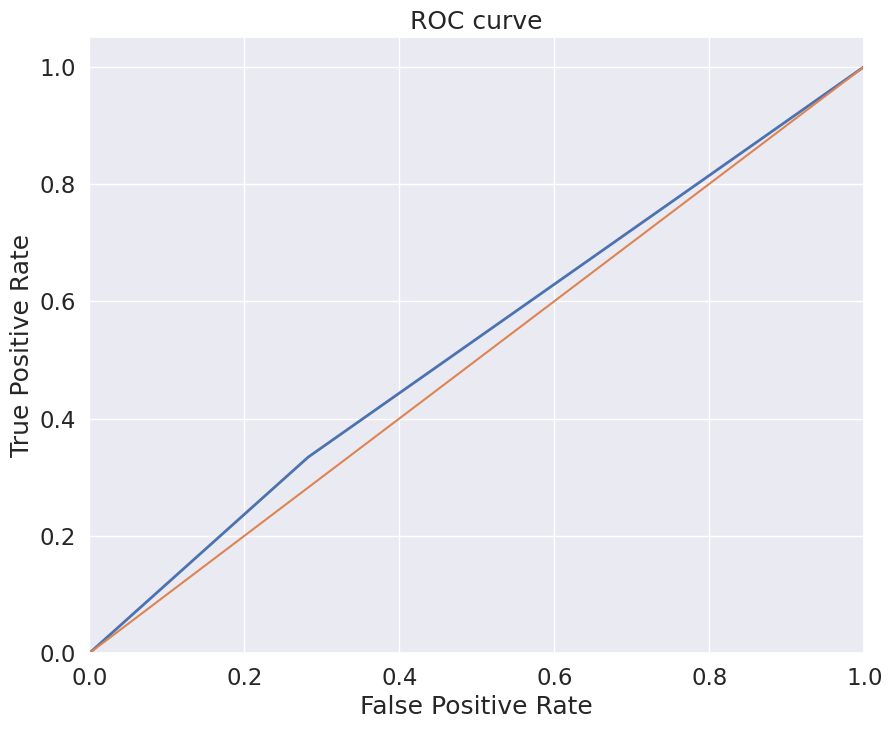

In [ ]:
model_logreg_high_metrics = Calc_of_metrics_and_Roc_Auc(model_logreg_high['model'], model_logreg_high['y_true_proba'],
                                                    model_logreg_high['y_true_predict'],
                                                    x_train, x_test, y_train, y_test)

#### 8.1.2 Cnfusion matrix plot

Confusion matrix, without normalization
[[744 293]
 [641 322]]


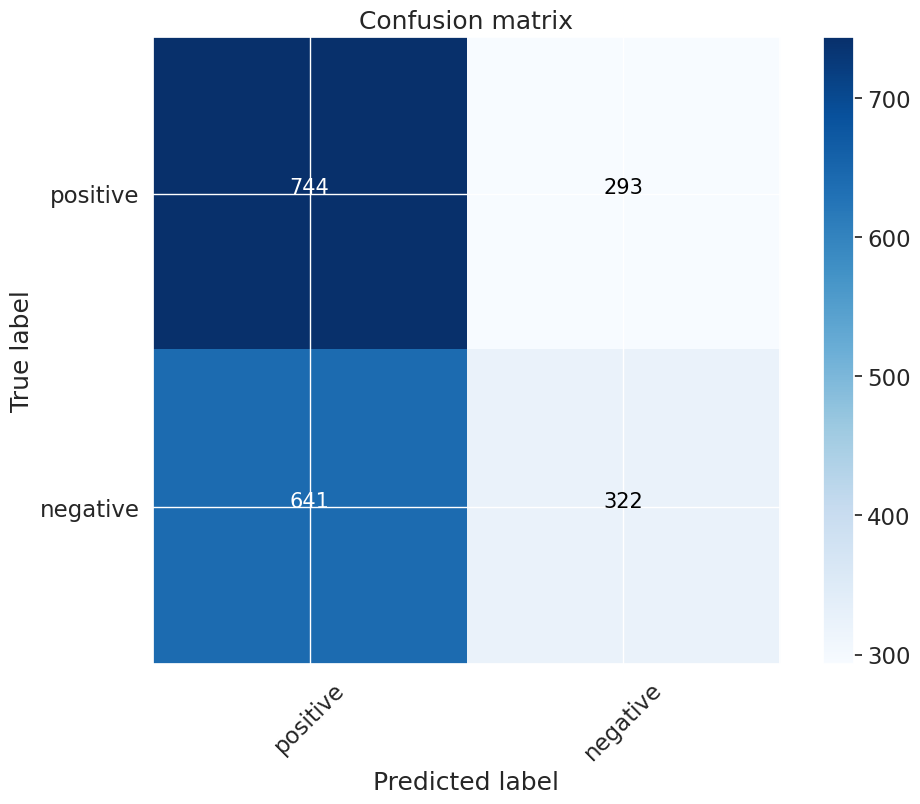

In [ ]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_logreg_high = confusion_matrix(y_test,
                                     model_logreg_high['y_true_predict'] > model_logreg_high_metrics['Thresholds'])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_logreg_high, classes=['positive', 'negative'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

### 8.2 Learn with middle frequency

In [ ]:
model_logreg_middle = model_learning(Pipe_middle,
                              LogisticRegression, model_params,
                              x_train, x_test, y_train, y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


#### 8.2.1 ROC curve plot

Best Threshold=0.361, F-Score=0.665, Precision=0.534, Recall=0.880

 ************************************************** 



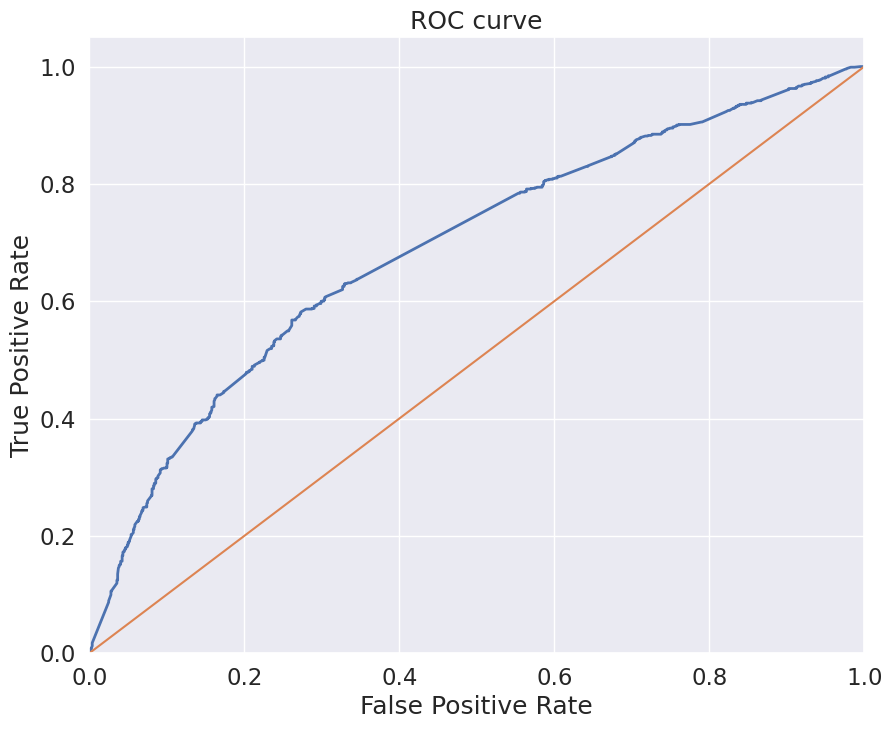

In [ ]:
model_logreg_middle_metrics = Calc_of_metrics_and_Roc_Auc(model_logreg_middle['model'],
                                                        model_logreg_middle['y_true_proba'],
                                                        model_logreg_middle['y_true_predict'],
                                                        x_train, x_test, y_train, y_test)

#### 8.2.2 Cnfusion matrix plot

Confusion matrix, without normalization
[[781 256]
 [443 520]]


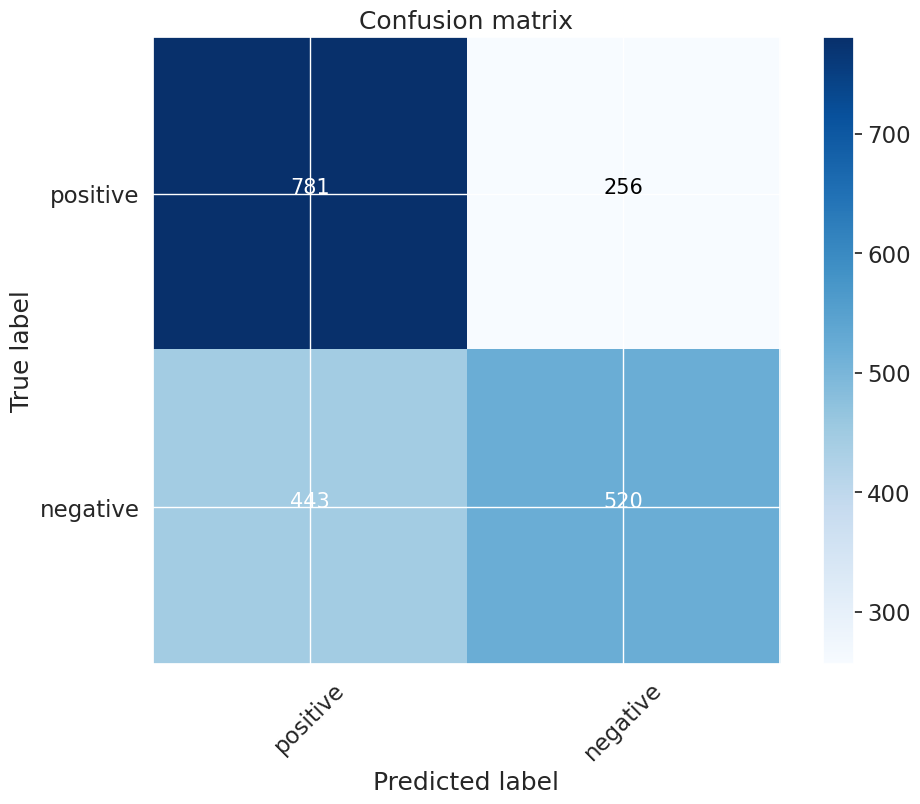

In [ ]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_logreg_middle = confusion_matrix(y_test,
                                     model_logreg_middle['y_true_predict'] > model_logreg_middle_metrics['Thresholds'])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_logreg_middle, classes=['positive', 'negative'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

### 8.3 Learn with lower frequency

In [ ]:
model_logreg_lower = model_learning(Pipe_min,
                              LogisticRegression, model_params,
                              x_train, x_test, y_train, y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


#### 8.3.1 ROC curve plot

Best Threshold=0.470, F-Score=0.840, Precision=0.799, Recall=0.886

 ************************************************** 



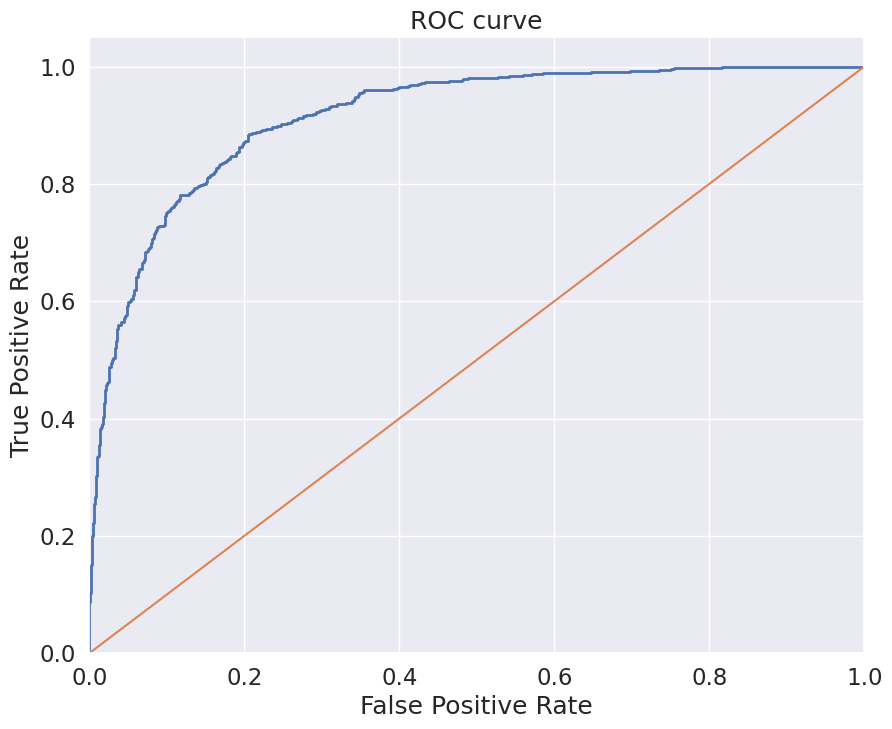

In [ ]:
model_logreg_lower_metrics = Calc_of_metrics_and_Roc_Auc(model_logreg_lower['model'],
                                                        model_logreg_lower['y_true_proba'],
                                                        model_logreg_lower['y_true_predict'],
                                                        x_train, x_test, y_train, y_test)

#### 8.3.2 Cnfusion matrix plot

Confusion matrix, without normalization
[[853 184]
 [154 809]]


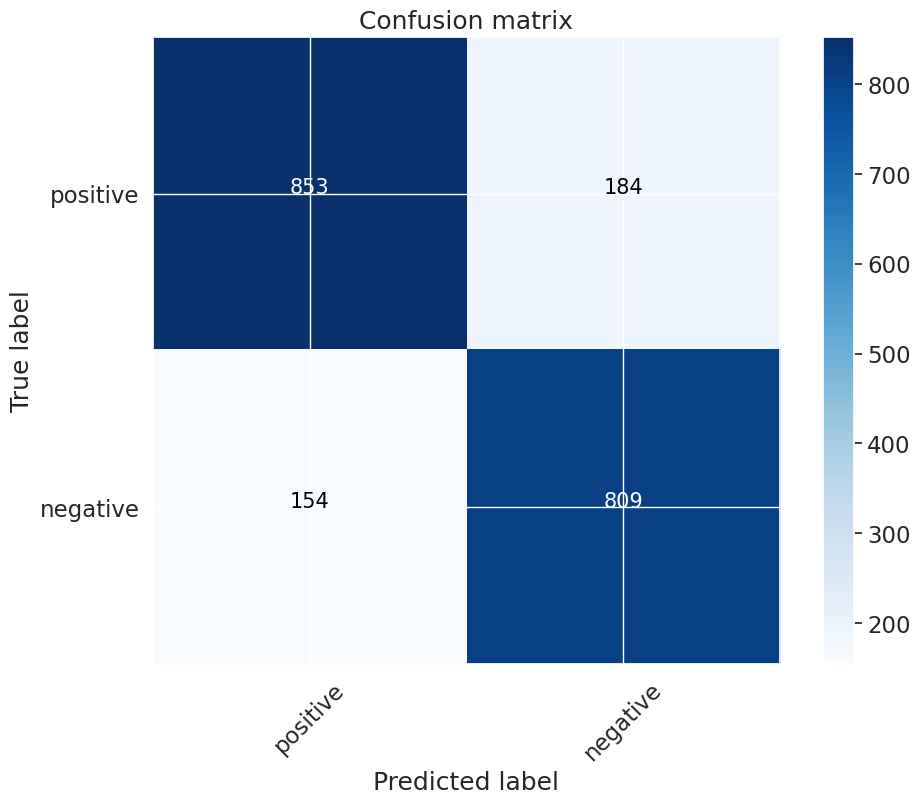

In [ ]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_logreg_lower = confusion_matrix(y_test,
                                     model_logreg_lower['y_true_predict'] > model_logreg_lower_metrics['Thresholds'])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_logreg_lower, classes=['positive', 'negative'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

## 9 SAVE Logreg model

In [ ]:
save_model_dill(path_to_work_dir + "LOGREG.dill", model_logreg_lower['model'])

## 10 Testing of model

### 10.1 LOAD Logreg model

In [ ]:
load_model_logreg = load_model_dill(path_to_work_dir + "LOGREG.dill")

### 10.2 Testing model

In [ ]:
a = 'Not so good - ok for a rental!: This 44game is pretty exciting and it is \
very nice and it is really creative and one of a kind234234. The only bad thing is \
that there is only one "castle" for the kids to "decorate" and once you are \
done with the whole castle that is basically it. You either have to create a \
new username for yourself to do it all over again or you get another game like \
I did. My sister finished the "castle in about 2 hours and after that has \
never even looked at this game anymore. It is a nice game and it is fun but \
it is not really worth that much money.'
b = "A FIVE STAR BOOK: I just finished reading Whisper of the Wicked saints. \
I fell in love with the caracters. I expected an average romance read, but \
instead I found one of my favorite books of all time. Just when I thought I \
could predict the outcome I was shocked ! The writting was so descriptive \
that my heart broke when Julia's did and I felt as if I was there with them \
instead of just a distant reader. If you are a lover of romance novels then \
this is a must read. Don't let the cover fool you this book is spectacular!"

In [ ]:
A = pd.DataFrame([a, b], columns=["tweet"])

In [ ]:
load_model_logreg.predict_proba(A)[:,1]

array([0.33518285, 0.37981568])

In [ ]:
y_test.iloc[:25].values.T[0]

array([0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0])

# IV Neural Network

## 11 Check device

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

***I decided to use the PyTorch for model and Tfidf for preprocessing data***

## 12 Split data

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.15, random_state=13)

In [ ]:
df_train, df_val = train_test_split(df_train, test_size=0.25, random_state=13)

In [ ]:
df_train.head()

,label,tweet
6624,1,Bravo!: Though some of the works here are bet...
6540,0,Not a great movie!: I thought it was pretty b...
733,0,A thorn in the side of literature.: Hawthorne...
2632,1,"Mum's the word, says Victorian novelist.: A q..."
1067,1,"The true meaning of Christmas, for kids: A Ch..."


In [ ]:
df_test.head()

,label,tweet
5952,0,bad product: i received a damaged product I c...
1783,1,Gun Digest: The book was bought as a gift for...
4811,1,Telemann: Sinfonia spirituosa; String Concert...
145,0,"Good for a laugh: I heard about this book, so..."
7146,0,Wax coating and taste: I try new energy/prote...


In [ ]:
df_val.head()

,label,tweet
2406,1,This book is has inspired me: This book would...
6006,1,Excellent!!!!!!!!!!!!!!!!!!!!!!!!: Don't have...
4728,0,DocuMate 510 is Horrible: This scanner is abs...
2358,1,"Beautiful, Poetic, Distinctive Writing: I lov..."
4992,1,"quarter through, and totally imressed: I have..."


In [ ]:
df_train['label'].value_counts()

0    3270
1    3105
Name: label, dtype: int64

In [ ]:
df_test['label'].value_counts()

0    756
1    744
Name: label, dtype: int64

In [ ]:
df_val['label'].value_counts()

0    1071
1    1054
Name: label, dtype: int64

In [ ]:
df_train.shape, df_val.shape, df_test.shape

((6375, 2), (2125, 2), (1500, 2))

## 13 Preprocessing data

In [ ]:
vectorizer_params = {
    "TfidfVectorizer" : {
        "analyzer": "word",
        "stop_words": "english",
        "max_features": 1000
    }
}

In [ ]:
par = vectorizer_params['TfidfVectorizer']

In [ ]:
P = Preprocessing_data(df_train, df_val, df_test, cln_txt_key='tweet', tfidf_params=par)

In [ ]:
P.data_preprocessing()

100%|██████████| 1500/1500 [00:03<00:00, 383.32it/s]


In [ ]:
x_train, x_val, x_test = P.results(15)

In [ ]:
x_train.shape

(6375, 15)

In [ ]:
x_val.shape

(2125, 15)

In [ ]:
x_test.shape

(1500, 15)

## 14 Create DataLoader

In [ ]:
batch_size = 526
train_dataset = MyTextData(x_train, df_train['label'].values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = MyTextData(x_val, df_val['label'].values)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)

## 15 Create Model

In [ ]:
max_words = par['max_features']

In [ ]:
model = Model_Text(vocab_size=max_words, out_channel=1, use_last=False)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [ ]:
print(model)
print("Parameters:", sum([param.nelement() for param in model.parameters()]))

Model_Text(
  (embedding): Embedding(1000, 500)
  (lstm_b_1): LSTM(500, 250, batch_first=True, dropout=0.2, bidirectional=True)
  (lstm_1): LSTM(500, 250, batch_first=True, dropout=0.2)
  (srnn): RNN(250, 125, batch_first=True)
  (drop_1): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=125, out_features=62, bias=True)
  (fc2): Linear(in_features=62, out_features=31, bias=True)
  (fc3): Linear(in_features=31, out_features=15, bias=True)
  (fc4): Linear(in_features=15, out_features=1, bias=True)
)
Parameters: 2813386


## 16 Create optimizer and function loss

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

## 17 Learn of model

In [ ]:
epochs = 20
model = model.to(device)
model.train()
th = 0.5

train_loss_history = []
test_loss_history = []


for epoch in range(epochs):
    running_items, running_right = 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        # print(inputs.size())

        # обнуляем градиент
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        running_items += len(labels)
        # подсчет метрики на обучении
        pred_labels = torch.squeeze((outputs > th).int())
        running_right += (labels == pred_labels).sum()

    # выводим статистику о процессе обучения
    model.eval()

    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
            f'Step [{i + 1}/{len(train_loader)}]. ' \
            f'Loss: {loss:.3f}. ' \
            f'Acc: {running_right / running_items:.3f}', end='. ')
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    train_loss_history.append(loss)

        # выводим статистику на тестовых данных
    test_running_right, test_running_total, test_loss = 0.0, 0.0, 0.0
    for j, data in enumerate(val_loader):
        test_labels = data[1].to(device)
        test_outputs = model(data[0].to(device))

        # подсчет ошибки на тесте
        test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
        # подсчет метрики на тесте
        test_running_total += len(data[1])
        pred_test_labels = torch.squeeze((test_outputs > th).int())
        test_running_right += (test_labels == pred_test_labels).sum()

    test_loss_history.append(test_loss.item())
    print(f'Test loss: {test_loss:.3f}. Test acc: {test_running_right / test_running_total:.3f}')

    model.train()

print('Training is finished!')

Epoch [1/20]. Step [13/13]. Loss: 0.471. Acc: 0.644. Test loss: 0.730. Test acc: 0.748
Epoch [2/20]. Step [13/13]. Loss: 0.588. Acc: 0.777. Test loss: 0.454. Test acc: 0.752
Epoch [3/20]. Step [13/13]. Loss: 0.452. Acc: 0.829. Test loss: 0.281. Test acc: 0.778
Epoch [4/20]. Step [13/13]. Loss: 0.195. Acc: 0.864. Test loss: 1.348. Test acc: 0.787
Epoch [5/20]. Step [13/13]. Loss: 0.228. Acc: 0.899. Test loss: 0.636. Test acc: 0.780
Epoch [6/20]. Step [13/13]. Loss: 0.153. Acc: 0.931. Test loss: 0.862. Test acc: 0.769
Epoch [7/20]. Step [13/13]. Loss: 0.165. Acc: 0.947. Test loss: 0.071. Test acc: 0.773
Epoch [8/20]. Step [13/13]. Loss: 0.164. Acc: 0.961. Test loss: 0.752. Test acc: 0.770
Epoch [9/20]. Step [13/13]. Loss: 0.093. Acc: 0.968. Test loss: 0.751. Test acc: 0.774
Epoch [10/20]. Step [13/13]. Loss: 0.086. Acc: 0.974. Test loss: 0.603. Test acc: 0.766
Epoch [11/20]. Step [13/13]. Loss: 0.037. Acc: 0.981. Test loss: 2.658. Test acc: 0.772
Epoch [12/20]. Step [13/13]. Loss: 0.089.

## 18 Visualisation of result learning model

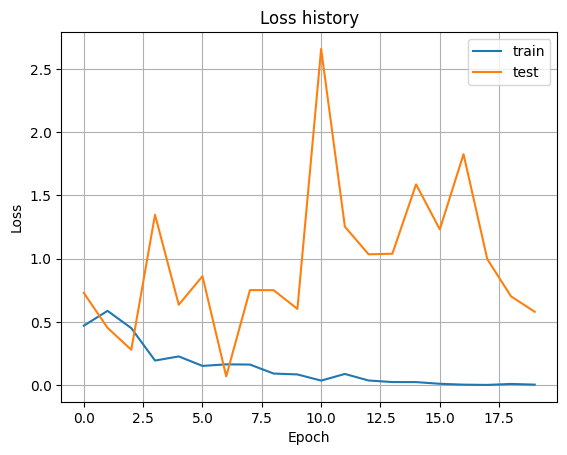

In [ ]:
plt.title('Loss history')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(train_loss_history, label='train')
plt.plot(test_loss_history, label='test')
plt.legend()

In [ ]:
torch.save(model, path_to_work_dir + "Torch_model.pth")

## 19 Make clasification report

In [ ]:
pt_model_load = torch.load(path_to_work_dir + "Torch_model.pth")

In [ ]:
y_pred = pt_model_load(torch.from_numpy(x_test))

In [ ]:
y_pred = y_pred.detach().numpy()

In [ ]:
y_pred_bin = []
for y in y_pred:
    if y > 0.5:
        y_pred_bin.append(1)
    else:
        y_pred_bin.append(0)

In [ ]:
y_test = df_test['label']

In [ ]:
print(classification_report(y_test, y_pred_bin))

              precision    recall  f1-score   support

           0       0.75      0.77      0.76       756
           1       0.76      0.75      0.75       744

    accuracy                           0.76      1500
   macro avg       0.76      0.76      0.76      1500
weighted avg       0.76      0.76      0.76      1500



# V Conclusion

График функции потерь четко отражает хорошую обучаемость NN на тренировочных данных, но очень плохо справляется с тестовыми данными, это чвязано с малым объемом выборки используемой для обучения модели. Аналогичный пример обработки данных с большим объемом данных представлен [здесь](https://colab.research.google.com/drive/1c3CN3kBfnAuI7XSUS2Uw-Zl6zjJCgvpZ): где на [графике](https://colab.research.google.com/drive/1c3CN3kBfnAuI7XSUS2Uw-Zl6zjJCgvpZ#scrollTo=Ro8iJKYCKGZU) можно увидеть улучшение результатов при условии увеличенного объема данных